# Preambule

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
from collections import OrderedDict
import pandas as pd
from scipy.stats import distributions as dst
import numpy as np

%config Completer.use_jedi = False

from matplotlib.patches import Rectangle

omeTag = "http://www.openmicroscopy.org/Schemas/OME/2016-06"

def printRecur(root, maxLevel=np.inf, stoppingCrit=None):
    """Recursively prints the tree."""
    global level
    try: Levels[level] += 1
    except: pass
    if stoppingCrit is not None:
        if stoppingCrit(Levels):
            return None
    title = root.tag.title().lower().replace(omeTag.lower(),"").replace("{}","")
    txt = root.text
    if txt is None: txt = ""
    else: txt =  ": "+txt
    count = ".".join(Levels.astype(int).astype(str))#.rstrip(".0")
    isplit = count.find(".0")
    if isplit>0:
        count = count[:isplit]
    count += (10-len(count))*" "
    print (count, end="")
    print (' '*4*level,title,txt)
    level += 1
    if level<=maxLevel:
        for elem in root:
            printRecur(elem, maxLevel=maxLevel,stoppingCrit=stoppingCrit)
    level -= 1
    Levels[level+1:] = 0

from sys import path as syspath
from os.path import expanduser
syspath.append(expanduser("~/Seafile/functions/"))
from general_functions import autocorr, tally

from general_functions import moving_average

## Parse metadata

In [2]:
filename = "Experiment.lif"

rdr = bf.ImageReader("./data/"+filename, perform_init=True)
md = bf.get_omexml_metadata("./data/"+filename)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()

In [4]:
%%time
FirstFrames = []
mdf = []
for i in range(Nimages):
    im = xml.image(index=i)
    tmp = OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]])
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)
    mdf += [tmp]
    FirstFrames += [rdr.read(series=i, rescale=False,t=0)]

mdf = pd.DataFrame(mdf)

try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except:
    pass

mdf#.loc[:,["X","Y","T","inferedTimes"]]

CPU times: user 4.68 s, sys: 52.7 ms, total: 4.74 s
Wall time: 4.55 s


,Name,AcquisitionDate,X,Y,T,C,Z
0,Image007,2019-05-16 10:50:30,1024,1024,1,1,1
1,Image008,2019-05-16 10:51:47,512,512,1,1,1
2,Image010,2019-05-16 10:52:46,1024,1024,1,1,1
3,Image012,2019-05-16 10:53:17,1024,1024,1,1,1
4,Series015,2019-05-16 10:54:37,512,512,780,1,1
5,Series016,2019-05-16 11:08:23,256,256,24521,1,1
6,Image018,2019-05-16 11:52:26,1024,1024,1,1,1
7,Series021,2019-05-16 11:54:58,64,64,8785,1,1
8,Image023,2019-05-16 12:00:18,1024,1024,1,1,1
9,Image025,2019-05-16 12:01:21,1024,1024,1,1,1


# Parse Annotations

In [5]:
import xml.etree.ElementTree as ET

In [6]:
realXML = xml.to_xml()

with open("tmp.xml","w") as f:
    f.write(realXML)
tree = ET.ElementTree(file="tmp.xml")
root = tree.getroot()

annotations = root[-1]

allFeatures = np.unique([" ".join(elem.text.split()[1:]) for elem in annotations.iter("{%s}"%omeTag+"Key")])

len(allFeatures)

197

In [7]:
%%time
features = pd.DataFrame(index=mdf.Name,columns=allFeatures)

for elem in annotations.iter("{%s}"%omeTag + "OriginalMetadata"):
    keys   = elem.findall(   "{%s}"%omeTag + "Key")
    values = elem.findall(   "{%s}"%omeTag + "Value")
    assert len(keys)==len(values)
    for k,v in zip(keys,values):
        name = k.text.split()[0]
        feature = " ".join(k.text.split()[1:])
        features.loc[name, feature] = v.text

CPU times: user 2.88 s, sys: 24.8 ms, total: 2.9 s
Wall time: 2.91 s


In [8]:
len(features.columns)

197

In [9]:
for ft in allFeatures:
    try:
        features[ft] = pd.to_numeric(features[ft], downcast="float")
    except:
        continue
        
    try:
        v = features[ft]
        vint = pd.to_numeric(v, downcast="integer")
        if np.sum((vint-v)**2)==0:
            features[ft] = vint
    except:
        continue

In [10]:
constFeatures = OrderedDict([(ft,features[ft].values[0]) for ft in allFeatures if len(features[ft].unique())==1])

In [11]:
# assert all numerical constanct values do NOT have NANs
assert np.all([np.isfinite(features[ft].values) for ft in constFeatures if type(constFeatures[ft])!=str])

In [12]:
varFeatures = [ft for ft in allFeatures if ft not in constFeatures]

features = features[varFeatures]

len(features.columns)

48

In [13]:
nameAlias = OrderedDict([(ft,ft.split("|")[-1].replace(" ","_").replace("#","")) for ft in varFeatures])

lineAvg = features.rename(columns=nameAlias)['nAverageLine_1']
# .idxsort()

mdf = mdf.join(lineAvg,on="Name")

mdf#.sort_values("nAverageLine_1")

,Name,AcquisitionDate,X,Y,T,C,Z,nAverageLine_1
0,Image007,2019-05-16 10:50:30,1024,1024,1,1,1,96
1,Image008,2019-05-16 10:51:47,512,512,1,1,1,16
2,Image010,2019-05-16 10:52:46,1024,1024,1,1,1,96
3,Image012,2019-05-16 10:53:17,1024,1024,1,1,1,96
4,Series015,2019-05-16 10:54:37,512,512,780,1,1,16
5,Series016,2019-05-16 11:08:23,256,256,24521,1,1,3
6,Image018,2019-05-16 11:52:26,1024,1024,1,1,1,128
7,Series021,2019-05-16 11:54:58,64,64,8785,1,1,2
8,Image023,2019-05-16 12:00:18,1024,1024,1,1,1,128
9,Image025,2019-05-16 12:01:21,1024,1024,1,1,1,96


## experiment a bit

In [14]:
addColls = ["DimensionDescription|Length", "DimensionDescription|Unit"]
renameColls = {c:c.replace("DimensionDescription|","Time") for c in addColls}
mdf = mdf.join(features[addColls].rename(renameColls,axis="columns"),on="Name")

In [46]:
vvs = []
for frame in FirstFrames:
    totVar = np.var(frame)
    vvs += [[np.mean(np.var(frame,axis=i)/totVar) for i in [0,1]]]

In [47]:
vvs = np.array(vvs).T

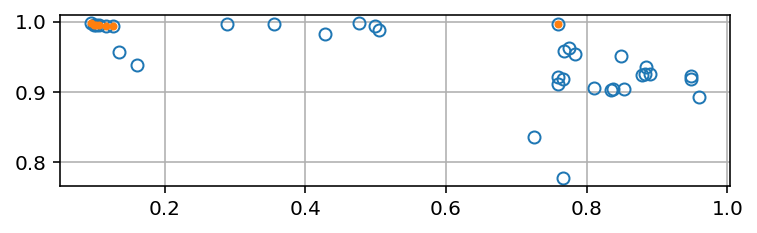

In [50]:
ax = plt.subplot(111)
ax.plot(vvs[0],vvs[1],"o",mfc="none")
fltr = (mdf["Y"]/mdf["X"]>3).values
ax.plot(vvs[0][fltr],vvs[1][fltr],".")
# ax.set_xscale("log")
# plt.yscale("log")
plt.grid()
ax.set_aspect("equal")

In [52]:
tmp = pd.Series((mdf["Y"]/mdf["X"]>3).values)
tmp.name="LineScan"
mdf.join(tmp).sort_values("Y", ascending=False)

,Name,AcquisitionDate,X,Y,T,C,Z,nAverageLine_1,TimeLength,TimeUnit,LineScan
22,Series059,2019-05-16 14:31:10,64,8192,14,1,1,3,10.000000,s,True
25,Series062,2019-05-16 14:40:31,64,8192,2,1,1,3,0.006000,s,True
26,Series063,2019-05-16 14:40:45,64,8192,2,1,1,3,0.006000,s,True
32,Series079,2019-05-16 15:08:29,512,2012,84,1,1,2,10.483000,s,True
9,Image025,2019-05-16 12:01:21,1024,1024,1,1,1,96,0.000137,m,False
15,Image038,2019-05-16 13:07:59,1024,1024,1,1,1,96,0.000420,m,False
13,Image033,2019-05-16 12:44:54,1024,1024,1,1,1,96,0.000332,m,False
12,Image032,2019-05-16 12:44:45,1024,1024,1,1,1,96,0.000332,m,False
11,Image030,2019-05-16 12:42:11,1024,1024,1,1,1,128,0.000450,m,False
0,Image007,2019-05-16 10:50:30,1024,1024,1,1,1,96,0.000456,m,False


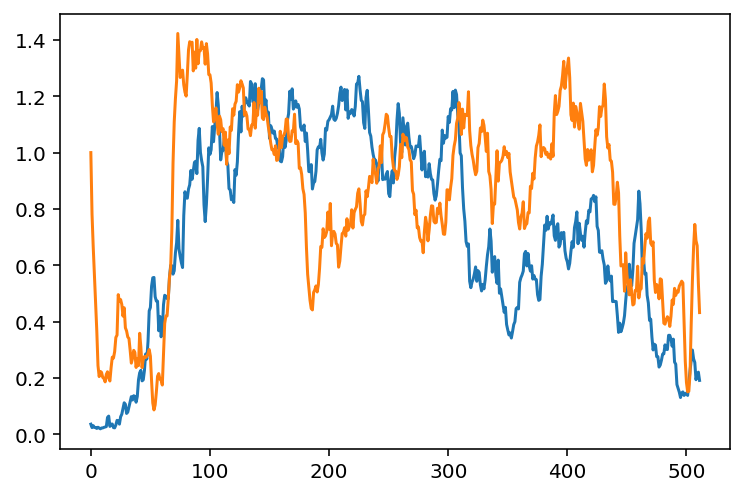

In [31]:
plt.plot(np.var(frame,axis=0)/totVar)
plt.plot(np.var(frame,axis=1)/totVar)

In [149]:
# mdf["TotTime"] = (1+59*(mdf["DimensionDescription|Unit"]=="m").astype(int))*mdf["DimensionDescription|Length"]

In [173]:
appFreq = mdf['T']/mdf["TimeLength"]
appFreq[mdf["TimeUnit"]=="m"] = np.nan
appFreq[~np.isfinite(appFreq)] = np.nan
mdf.join(pd.DataFrame({"apparentFreq":appFreq}))

,Name,AcquisitionDate,X,Y,T,C,Z,nAverageLine_1,TimeLength,TimeUnit,apparentFreq
0,Image007,2019-05-16 10:50:30,1024,1024,1,1,1,96,0.000456,m,NaN
1,Image008,2019-05-16 10:51:47,512,512,1,1,1,16,0.000456,m,NaN
2,Image010,2019-05-16 10:52:46,1024,1024,1,1,1,96,0.000456,m,NaN
3,Image012,2019-05-16 10:53:17,1024,1024,1,1,1,96,0.000456,m,NaN
4,Series015,2019-05-16 10:54:37,512,512,780,1,1,16,786.632996,s,0.991568
5,Series016,2019-05-16 11:08:23,256,256,24521,1,1,3,2473.095947,s,9.915103
6,Image018,2019-05-16 11:52:26,1024,1024,1,1,1,128,0.000350,m,NaN
7,Series021,2019-05-16 11:54:58,64,64,8785,1,1,2,177.585999,s,49.468990
8,Image023,2019-05-16 12:00:18,1024,1024,1,1,1,128,0.000137,m,NaN
9,Image025,2019-05-16 12:01:21,1024,1024,1,1,1,96,0.000137,m,NaN


In [ ]:
fre

In [151]:
mdf.query("DimensionDescription|Unit=='s'")
#.iloc[:,[0,2,3,4,-1]].sort_values("T").join(features["Har"])

UndefinedVariableError: name 'DimensionDescription' is not defined

# Choose Series

In [17]:
idx = 18#np.where(features.index==ix)[0][0]
Name = mdf.loc[idx,"Name"]
dimensions = mdf.loc[idx,list("XYZCT")]
image = np.array([
            rdr.read(series=idx, rescale=False,t=t, ) for t in range(dimensions["T"])
        ])

In [18]:
Name, image.shape

('Series051', (12524, 32, 512))

## See distributions and filter

In [19]:
Nsample = int(1e7)
pixelSample = np.random.choice(image.flatten(), Nsample)

In [20]:
x,y = np.array(tally(pixelSample)).T
xth =  80
yth = 1e5

<BarContainer object of 11 artists>

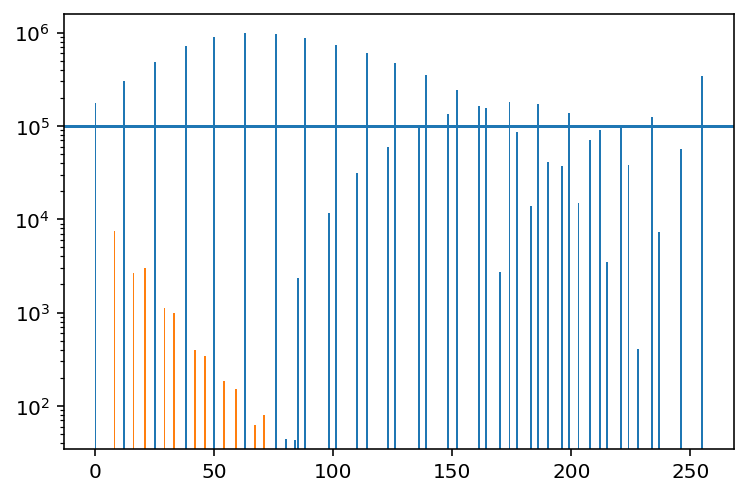

In [21]:
plt.bar(x,y)
plt.yscale("log")
plt.axhline(yth)
take = x[y<yth]
take = take[take<xth]

tmp = pixelSample
tmp = tmp[np.isin(tmp,take)]
x_noise,y_noise = np.array(tally(tmp)).T
plt.bar(x_noise,y_noise)

In [22]:
showTransposed = True

CPU times: user 606 ms, sys: 7.65 ms, total: 614 ms
Wall time: 612 ms


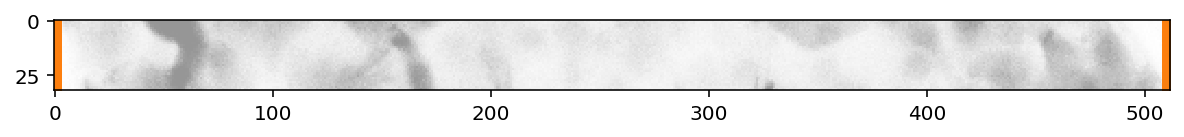

In [23]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in zip(*np.where(np.isin(ims[:],take))):
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [24]:
Nsample = int(1e7)
pixelSampleRed = np.random.choice(image.T[1:-1].flatten(), Nsample)
xRed,yRed = np.array(tally(pixelSampleRed)).T

In [25]:
tmp = xRed[yRed>yth]
tmp = tmp[tmp<xth]
meanDiff = np.diff(tmp).mean()

del tmp

In [26]:
meanDiff

12.666666666666666

In [27]:
collectBulk = [xRed[0]]
for el in xRed[1:-1]:
    if np.abs(el-collectBulk[-1]-meanDiff)<1.5:
        collectBulk += [el]

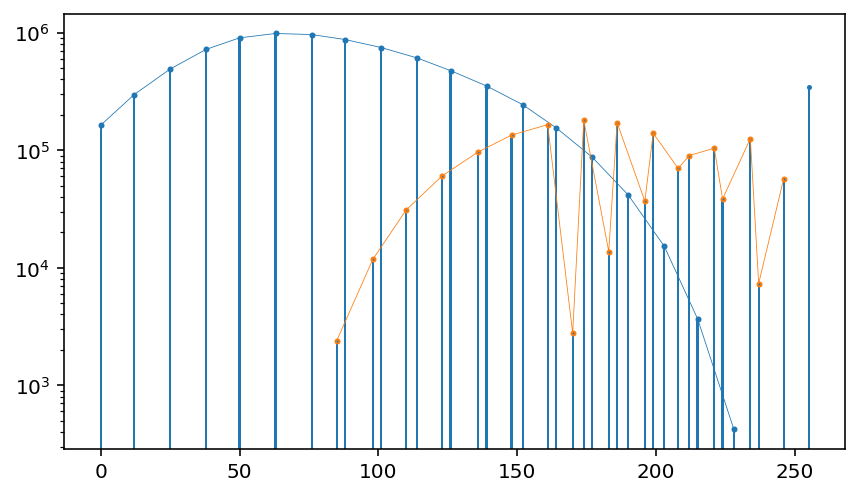

In [28]:
plt.figure(figsize=(7,4))
plt.bar(xRed,yRed,color="C0")
plt.plot(xRed,yRed,".-", ms=3, lw=0,color="C0")
plt.yscale("log")

fltr = np.isin(xRed, collectBulk)
for xf,yf in [
    (xRed[ fltr], yRed[ fltr]),
    (xRed[~fltr], yRed[~fltr]),
]:
    ff = xf!=xRed.max()
    xf = xf[ff]
    yf = yf[ff]
    plt.plot(xf,yf,".-", ms=4, lw=.4, mfc="none")

In [29]:
scale = np.diff(xRed[fltr]).mean()

In [30]:
np.diff(xf)

array([13, 12, 13, 13, 12, 13,  9,  4,  9,  3, 10,  3,  9,  4,  9,  3, 10,
        3,  9])

CPU times: user 807 ms, sys: 14.9 ms, total: 822 ms
Wall time: 820 ms


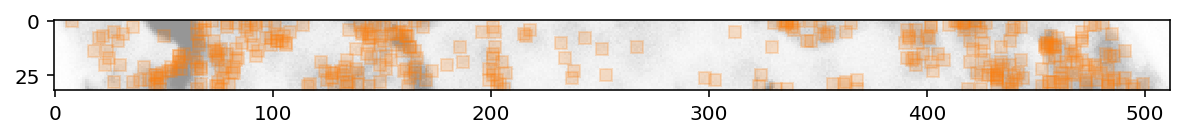

In [31]:
%%time
plt.figure(figsize=(10,4))
ims = image[::1000]
X = np.mean(ims,axis=0)
if not showTransposed: X = X.T
plt.imshow(X, cmap="Greys",vmax=2*256)
for t,x,y in list(zip(*np.where(np.isin(ims[:],xf))))[::100]:
    if showTransposed:
        x,y = y,x
    plt.plot(x,y,"C1s",
             alpha = .2
            )
#     if t>0:
#         break

In [32]:
# ## See features

# pd.options.display.max_rows = 100

# tmp = OrderedDict([(k,v) for k,v in constFeatures.items() if
#                                 "Filter" not in k and
#                                 "Channel" not in k and
#                                 "csLutName" not in k
#                                ])
# tmp.update(features.loc[Name])
# tmp = OrderedDict([(k.replace("|"," | "),v) for k,v in tmp.items()])
# tmp = pd.DataFrame(tmp, index=[0]).T
# print (len(tmp))
# tmp

In [33]:
# features[[c for c in features.columns if "nDelayTime" in c]]

# Choose ROI(s) and try analysis

In [34]:
TotalTime = features["DimensionDescription|Length"].loc[Name]

In [35]:
TotalTime

151.905

In [36]:
Frequency = dimensions["T"]/TotalTime

In [37]:
Frequency,Frequency*12

(82.44626642073938, 989.3551970488725)

In [38]:
timeStd = np.std(image, axis=0)

In [39]:
image.shape

(12524, 32, 512)

In [40]:
if Name == "Series051":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
        (np.arange(110,150),
         np.arange( 18, 31)),
        (np.arange(330,370),
         np.arange(  1, 18)),    
        (np.arange(390,410),
         np.arange(  1, 30)),    
        (np.arange(420,450),
         np.arange( 18, 31)),    
    ]
    

if Name == "Series052":
    RFs = [    
        (np.arange(dimensions["X"]),
         np.arange(dimensions["Y"])),
    ]
    RFs += [
        (np.arange(xx,xx+80),
         np.arange(dimensions["Y"])) for xx in [30,140,270,360]]    

RFs = OrderedDict(zip(range(len(RFs)),RFs))

In [41]:
list(map(lambda xi: len(xi[0]),RFs.values()))

[512, 40, 40, 20, 30]

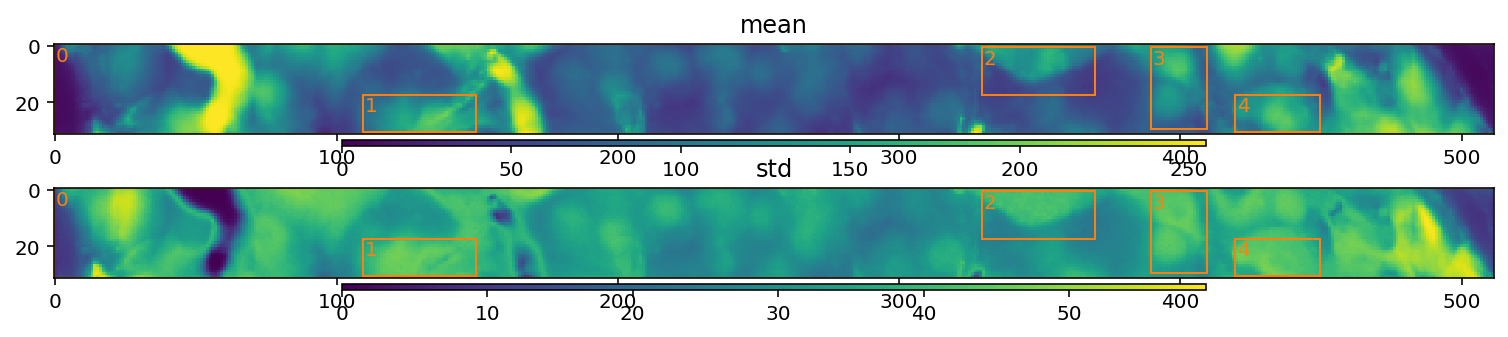

In [42]:
fig = plt.figure(figsize=(10,2))
if showTransposed:
    axs  = [fig.add_axes([  0,.07,1 ,.45]),fig.add_axes([ 0 ,.57, 1,.45]),]
    caxs = [fig.add_axes([0.2,.10,.6,.02]),fig.add_axes([0.2,.60,.6,.02]),]
else:
    axs  = [fig.add_axes([ 0 ,0,.4 ,1]),fig.add_axes([.5 ,0,.4 ,1]),]
    caxs = [fig.add_axes([.41,0,.02,1]),fig.add_axes([.91,0,.02,1]),]


for X,ax,cax,name in zip([timeStd,np.mean(image,axis=0)],axs,caxs,["std","mean"]):
    if not showTransposed:X = X.T
    im_ = ax.imshow(X, vmin=0)
    plt.colorbar(im_, cax=cax,orientation="horizontal")
    ax.set_title(name)
    ir = 0
    for rfname in RFs:
        regionFilter = RFs[rfname]
        roi = Rectangle(
            (regionFilter[0].min()-.5,regionFilter[1].min()-.5),
            width=len(regionFilter[0]),
            height=len(regionFilter[1]),
            fill=False,
            edgecolor="C1"
        )
        ax.add_patch(roi)
        ax.text(regionFilter[0].min(),regionFilter[1].min(),rfname,color="C1",va="top")
        ir+=1


In [43]:
time = np.linspace(0,TotalTime,dimensions["T"])

In [44]:
AllProfiles = OrderedDict()

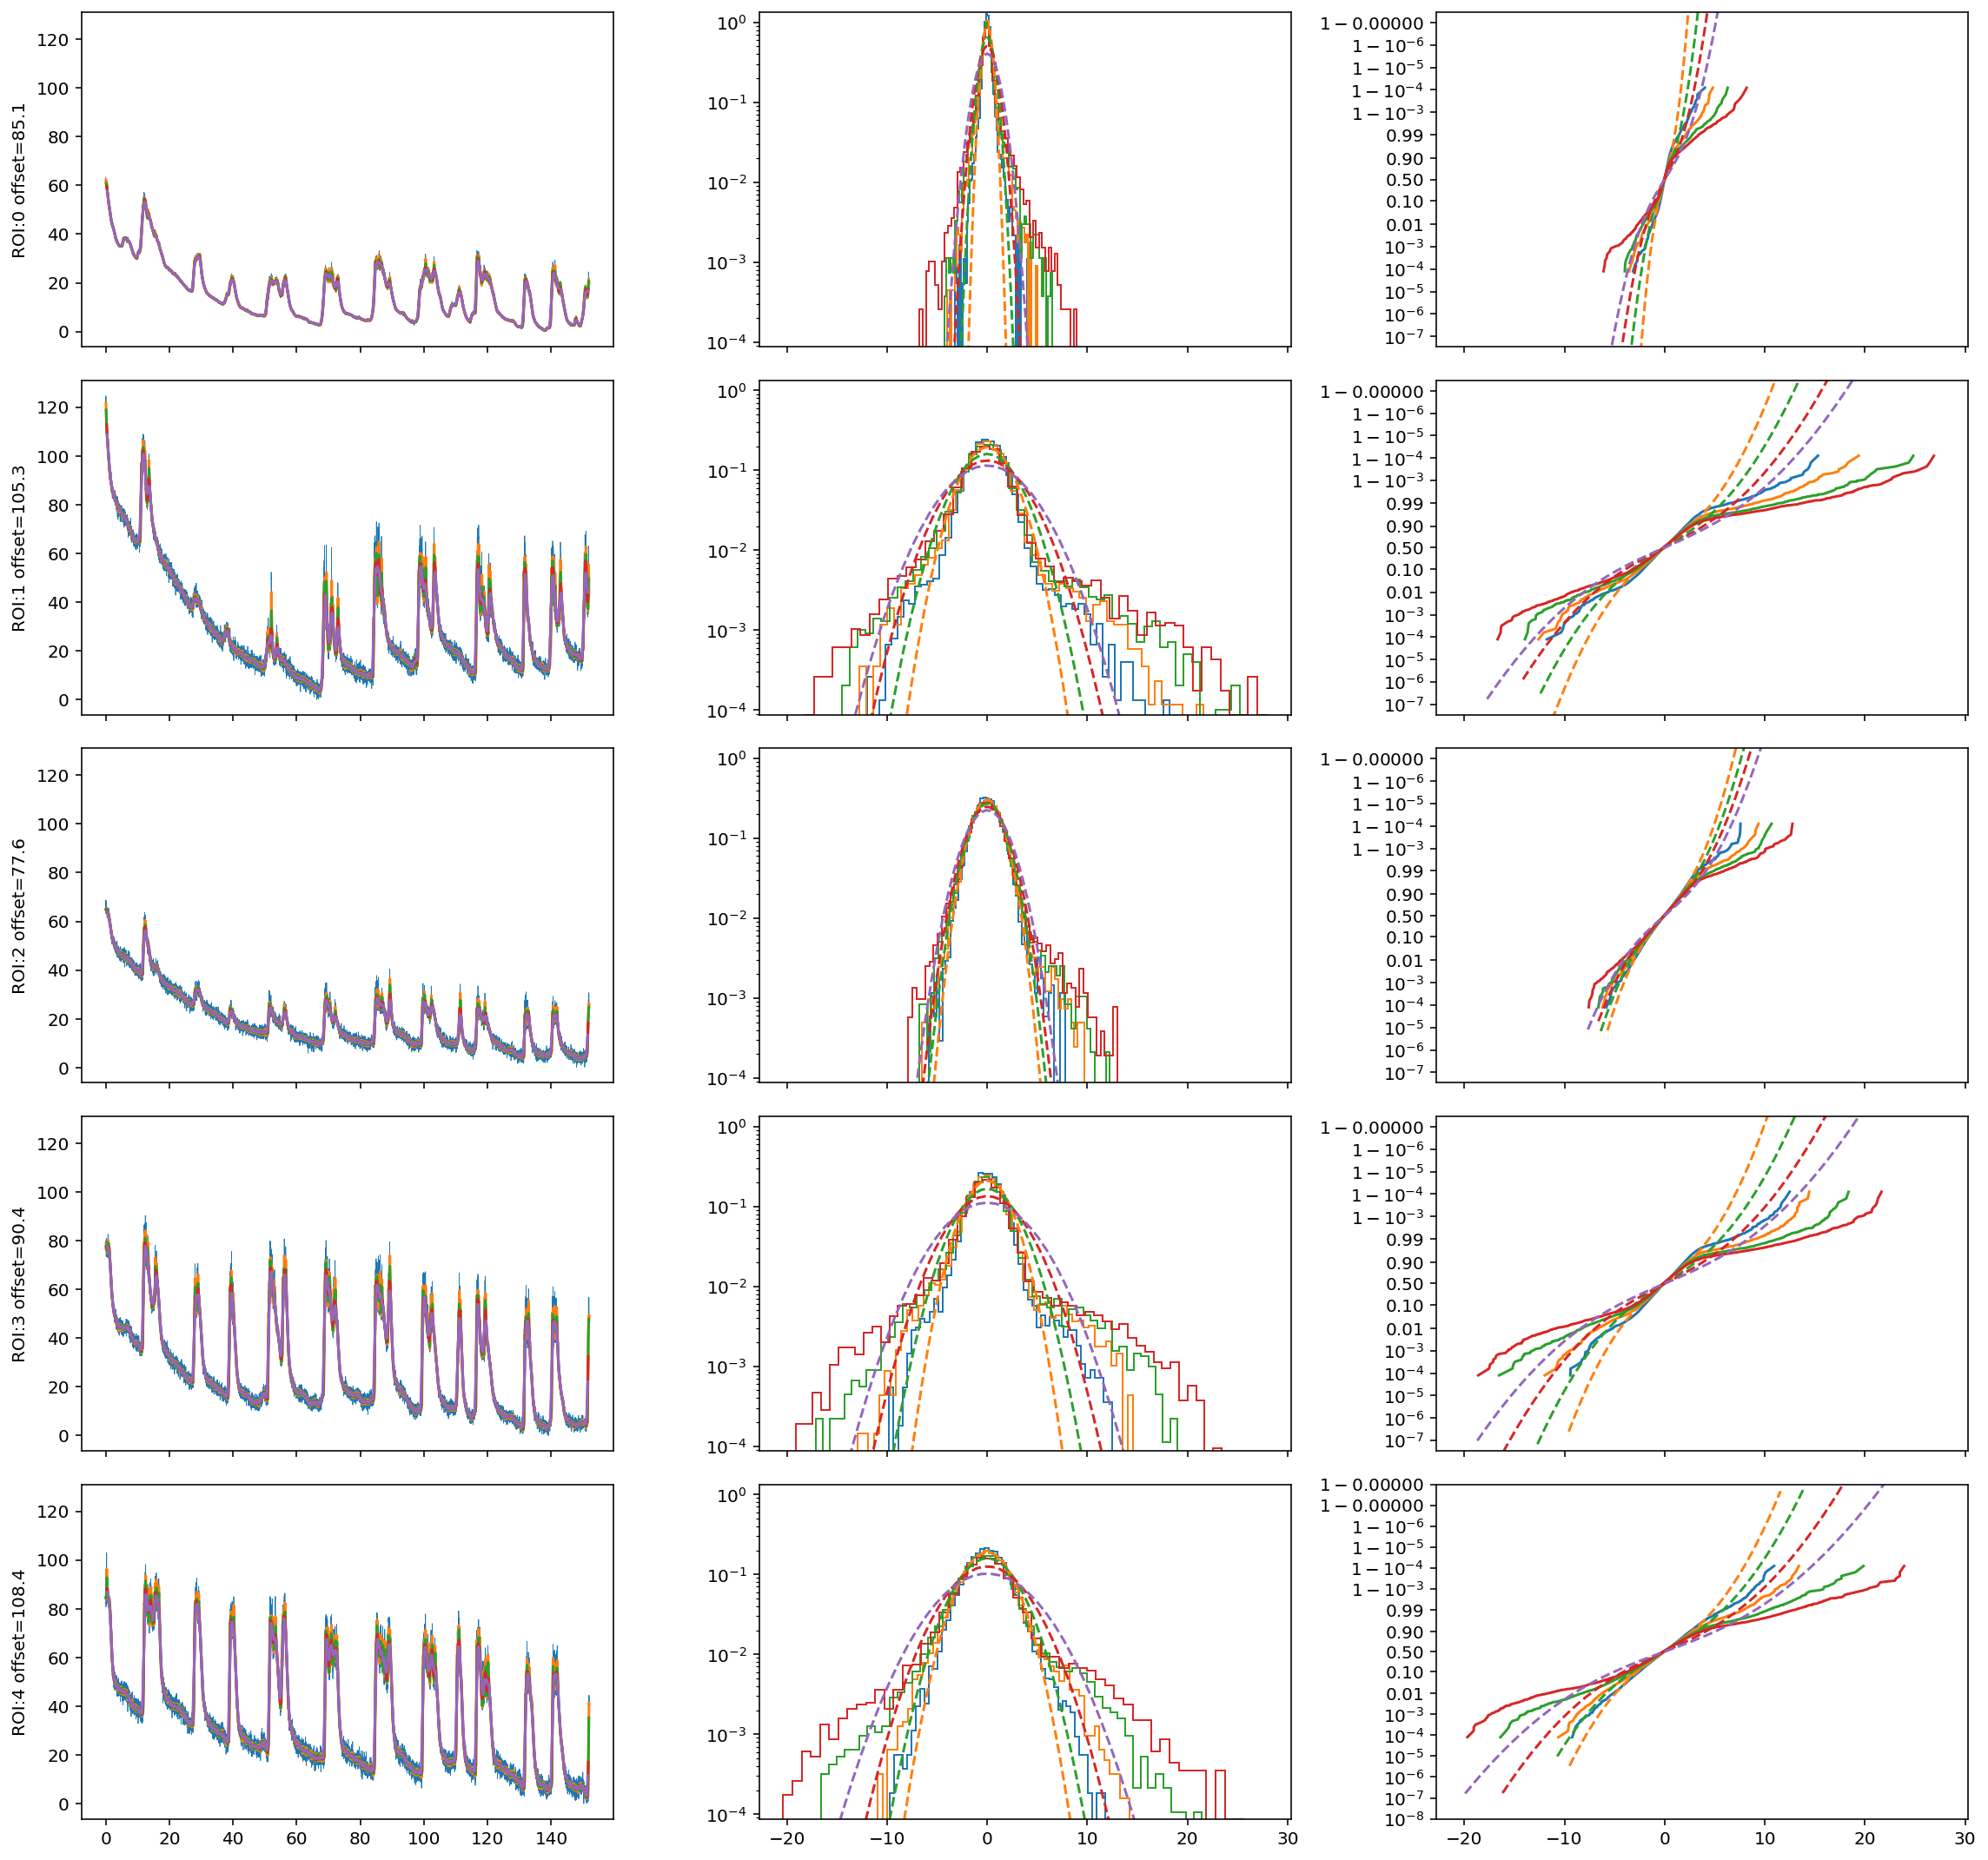

In [45]:
# showRFs = {0:RFs[0]}
showRFs = RFs
fig, Axs = plt.subplots(len(showRFs),3,figsize=(16,3*len(showRFs)), sharex="col", sharey="col")
if len(Axs.shape)==1:
    Axs=Axs.reshape(1,-1)

for ir,rfname in enumerate(showRFs):
    regionFilter = RFs[rfname]
    axs = Axs[ir]
    timeProfile = np.mean(image.T[np.ix_(*regionFilter)].T, axis=(1,2))
    offset = timeProfile.min()
    axs[0].plot(time,timeProfile-offset,lw=.4)
    profileAverages = OrderedDict([("raw",timeProfile)])
    for dtAvg in [10,20,50,80]:
        dtAvg -= 1
        timeProfileAvg = moving_average(timeProfile,dtAvg)
        timeAvg = moving_average(time, dtAvg)
        rest = timeProfile[dtAvg//2:-(dtAvg//2)]-timeProfileAvg
        profileAverages[dtAvg+1] = pd.DataFrame(OrderedDict([
            ("time", timeAvg),
            ("smooth", timeProfileAvg),
            ("rest", rest),
        ]))
        c = axs[0].plot(timeAvg,timeProfileAvg-offset,
#                         label="offset=%.1f"%timeProfileAvg.mean()
                       )[0].get_color()
        yb,bbs,_ = axs[1].hist(rest,50,histtype="step",density=True)
        xb = (bbs[:-1]+bbs[1:])/2
        restStd = rest.std()
        axs[1].plot(xb,dst.norm.pdf(xb,scale=restStd),c=c,ls="--")
        x = rest.copy()
        axs[1].set_ylim(yb[yb>0].min(),)
        axs[2].plot(sorted(x),np.linspace(0,1,len(x)))
        axs[2].plot(xb,dst.norm.cdf(xb,scale=restStd),c=c,ls="--")
#     axs[0].legend()
    axs[0].set_ylabel("ROI:%s offset=%.1f"%(repr(rfname),offset))
    axs[1].set_yscale("log")
    axs[2].set_yscale("logit")
    axs[2].set_yticks(axs[2].get_yticks())
    yx = axs[2].yaxis
    l = yx.get_minor_locator()
    l.minor = False
#     break
    AllProfiles[rfname] = profileAverages
fig.tight_layout()

<IPython.core.display.Javascript object>


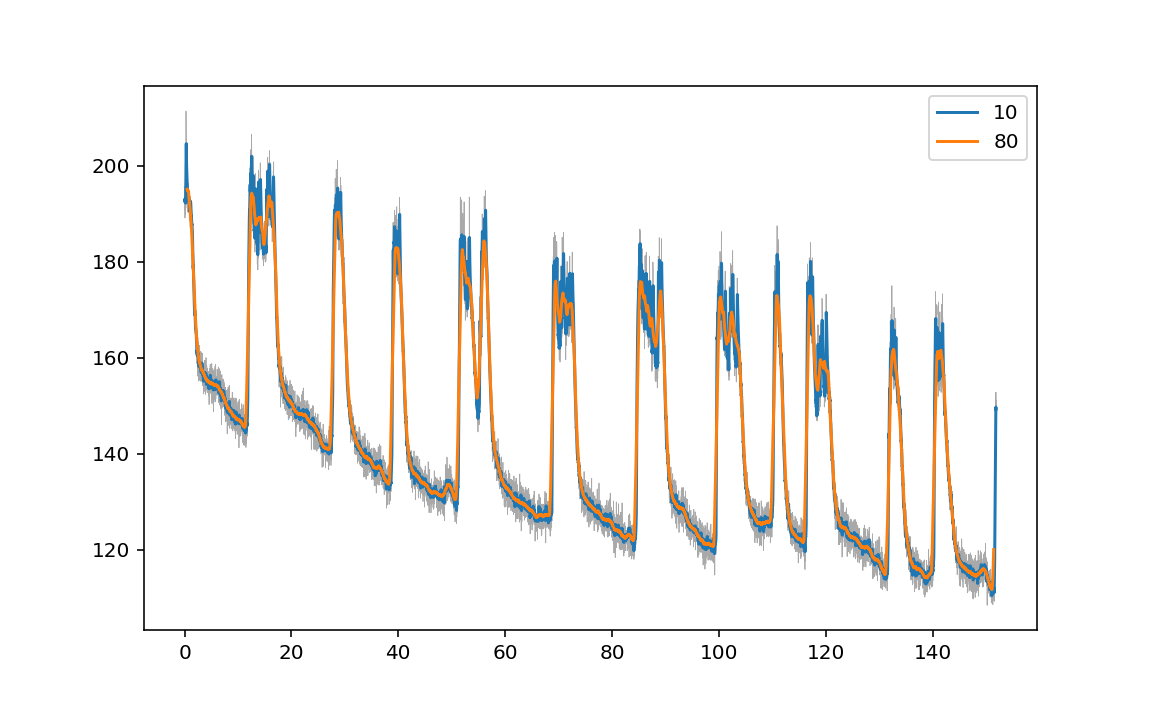

In [47]:
from importlib import reload
reload(plt)
%matplotlib notebook

rfname = 4

plt.figure(figsize=(8,5))

tmp = AllProfiles[rfname]
# for dtAvg in tmp:
for dtAvg in ["raw",10,80]:
    if dtAvg=="raw":
        plt.plot(time,tmp["raw"],color="darkgrey",lw=.4)
    else:
        t,x = tmp[dtAvg][["time","smooth"]].values.T
        plt.plot(t,x,label=dtAvg)
plt.legend()

In [144]:
filename, Name

('Experiment.lif', 'Series052')

## FFT

In [48]:
%matplotlib inline

In [118]:
trace1 = tmp["raw"]
trace1 -= trace1.mean()
dt  = TotalTime/len(trace1)
FTs = np.fft.fft(trace1)
N   = len(trace1)
freqs = np.fft.fftfreq(N,dt)
FAs = np.abs(FTs)


In [119]:
PowerSpectrum = FAs**2/(1/dt)**2
print (np.sum(PowerSpectrum)*freqs[1])
print (np.sum(trace1**2)*dt)

71433.8045357824
71433.80453578239


In [120]:
def filterF(x,th=1,h=1):
    return 1/(th**2+x**2)**h

In [121]:

Nshow = N//2
l1 = plt.plot(freqs[:Nshow],PowerSpectrum[:Nshow], label='raw',
              color="darkgreen")
# smooth = 3
# l2 = plt.plot(freqs[smooth//2:Nshow-smooth//2],
#          moving_average(PowerSpectrum[:Nshow], smooth),
#               label='smoothed scale=%i'%smooth, color="indigo")

plt.ylabel('power spectrum')
plt.xlabel('frequency (Hz)')
# plt.xlim(2*freqs[1],10.**3.9)
plt.yscale('log')
plt.xscale('log')
plt.twinx()
# plt.xlim(2*freqs[1],10.**3.9)

xr = np.logspace(-2,2.1, 201)

l3 = plt.plot(xr,filterF(xr), label="filter", color="red", ls="--",lw=2)
plt.ylabel('single pole filter')

# lns = l1+l2+l3
# labs = [l.get_label() for l in lns]
# plt.legend(lns, labs, loc=3)
plt.legend()

In [100]:
from importlib import reload
reload(plt)

<IPython.core.display.Javascript object>


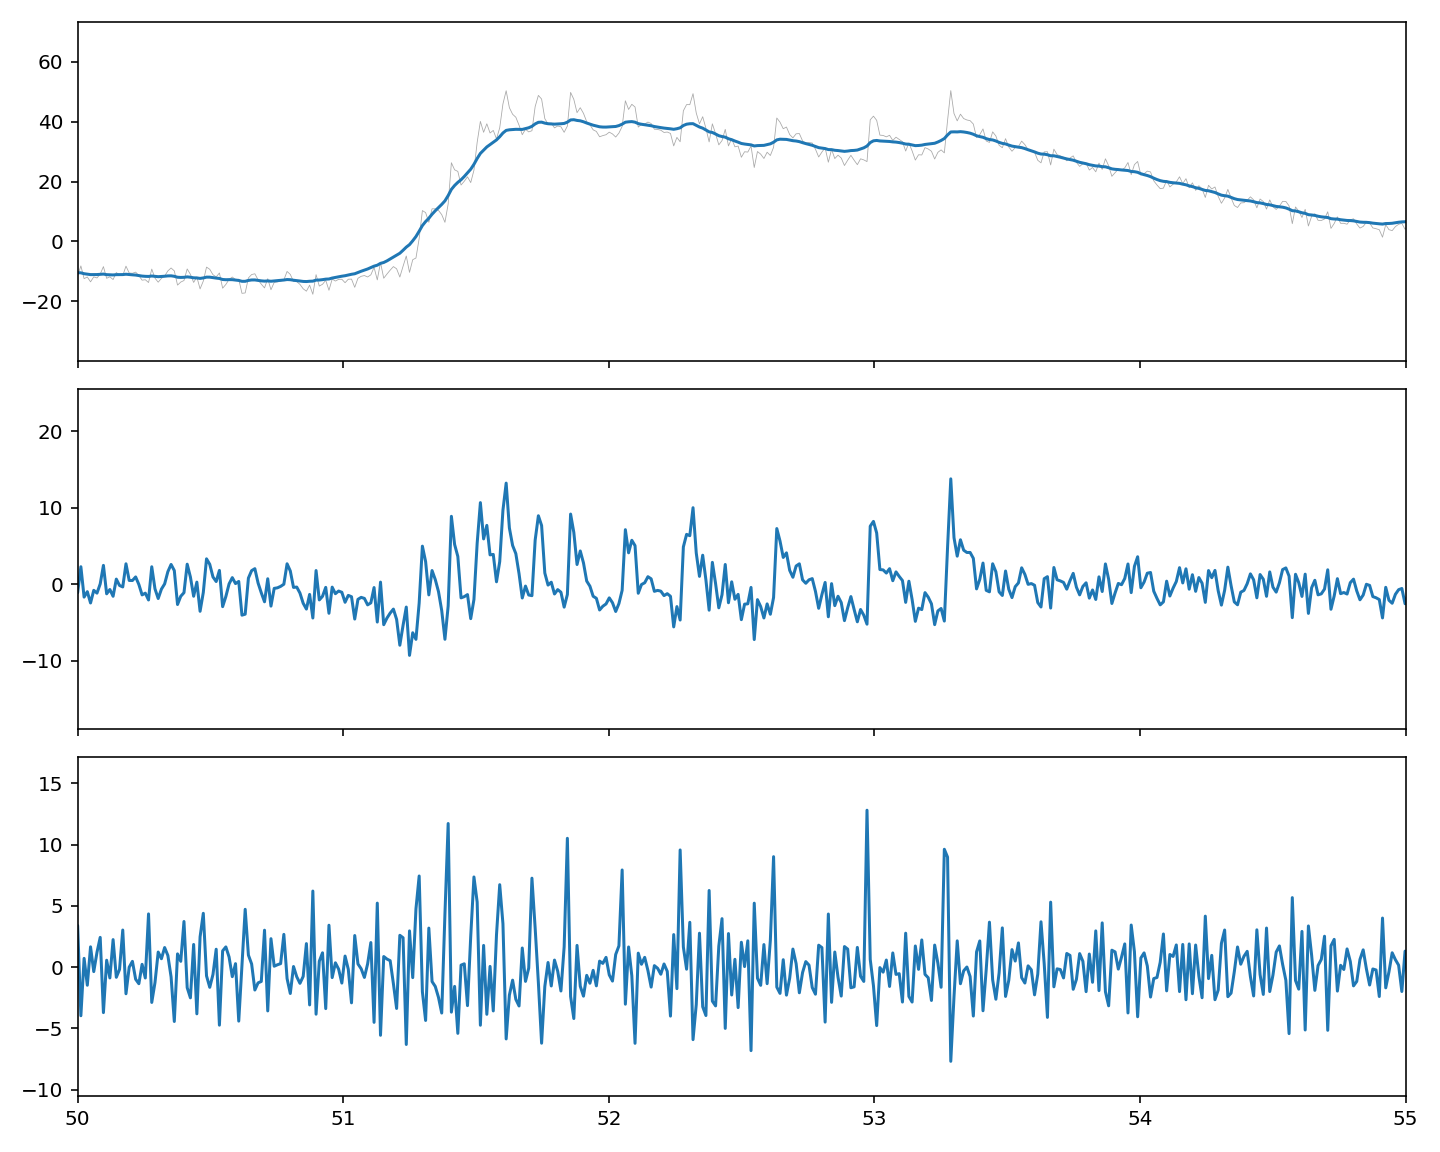

In [145]:
%matplotlib notebook
fig, axs = plt.subplots(3,1,figsize=(10,8), sharex=True)
axs[0].plot(time,trace1,color="darkgrey",lw=.4)

for th in [1]:
    filteredFT = FTs*filterF(freqs,th=th)**.5
    filteredTrace = np.real_if_close(np.fft.ifft(filteredFT))
    axs[0].plot(time,filteredTrace)
    axs[1].plot(time,trace1-filteredTrace)
#     axs[2].plot(time[:-1],np.diff(trace1))
    axs[2].plot(time[:-1],np.diff(trace1-filteredTrace))

axs[1].set_xlim(50,55)
fig.tight_layout()

<IPython.core.display.Javascript object>


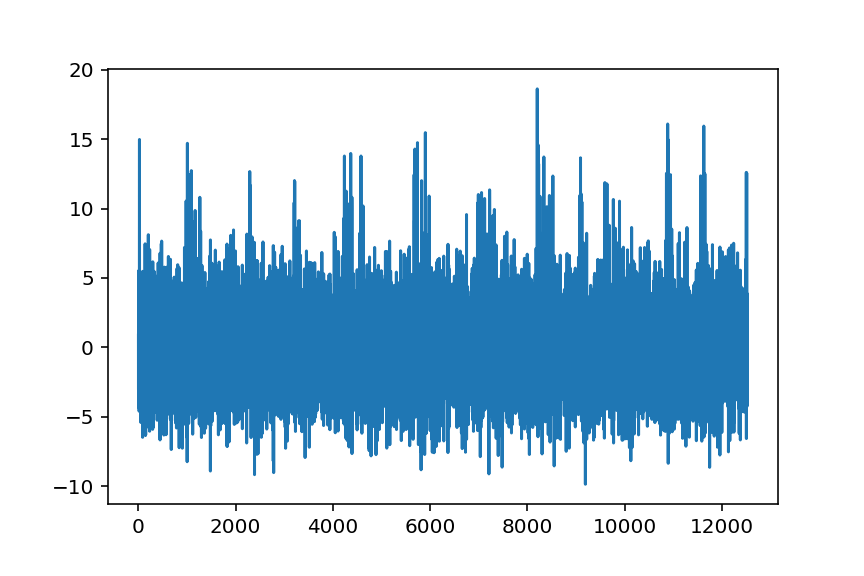

In [141]:
%matplotlib notebook
plt.plot(np.diff(trace1))

In [185]:
filteredTrace.shape, trace1.shape

((685,), (685,))

In [103]:
# "freq" in 
k = list(constFeatures.keys())[0]
k.lower(),np.isin(["inc","|"],k.lower())

('channeldescription|bitinc', array([False, False]))

In [117]:
fltrkeys = [
        "freq",
        "time",
        "dwell",
#         "length",
        "delay",
        "expo",
        "gain",
        "integ",
]
pd.concat([
    mdf.loc[idx],
    features.loc[Name,[c for c in features.columns if np.any([l in c.lower() for l in fltrkeys])]],
    pd.Series(OrderedDict([(k.replace("|"," | "),v) for k,v in constFeatures.items() if np.any([l in k.lower() for l in fltrkeys])])),
])

Name                                                                                      Series051
AcquisitionDate                                                                 2019-05-16 14:14:16
X                                                                                               512
Y                                                                                                32
T                                                                                             12524
C                                                                                                 1
Z                                                                                                 1
nAverageLine_1                                                                                    3
HardwareSetting|FilterSettingRecord|HyD 1 (Gain) #1                                              24
HardwareSetting|FilterSettingRecord|X Reson. Scan Actuator (Gain) #1                        3.09594


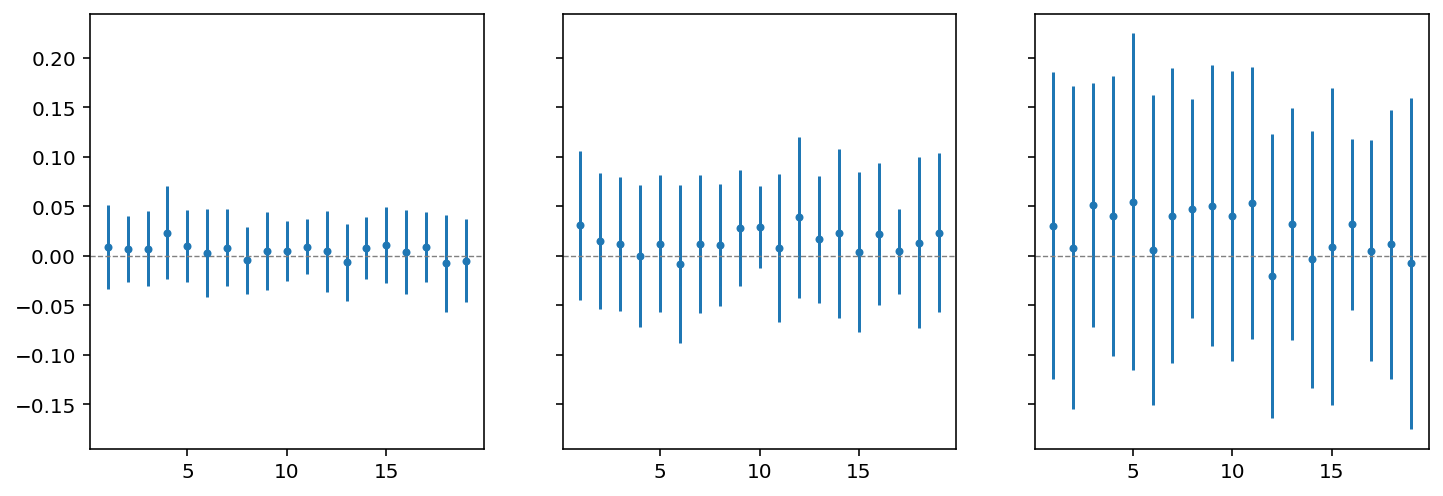

In [331]:
xr = np.arange(1,20)
dtBin = 3
nc = 3
fig, axs = plt.subplots(1,nc,figsize=(nc*4,4), sharex=True, sharey=True)
for i in range(nc):
    ax = axs.flat[i]
#     plt.subplot(1,nc,i+1)
    if i==0:
        X = timeProfile.copy()
    else:
        nTime = len(X)
        X = X[:nTime//dtBin*dtBin].reshape(nTime//dtBin,dtBin).mean(axis=1)
    yr, ye = autocorr(X, xr,nsplits=20)
    ax.errorbar(xr,yr,ye,ls="none",marker=".")
    ax.axhline(0,color='grey', ls="--", lw=.7)
#     plt.show()

(-13.190000000000001, 268.19)

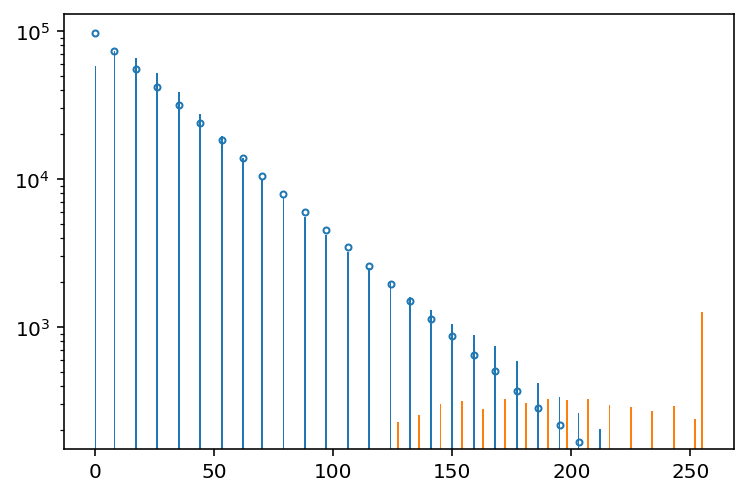

In [51]:


realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

<BarContainer object of 7 artists>

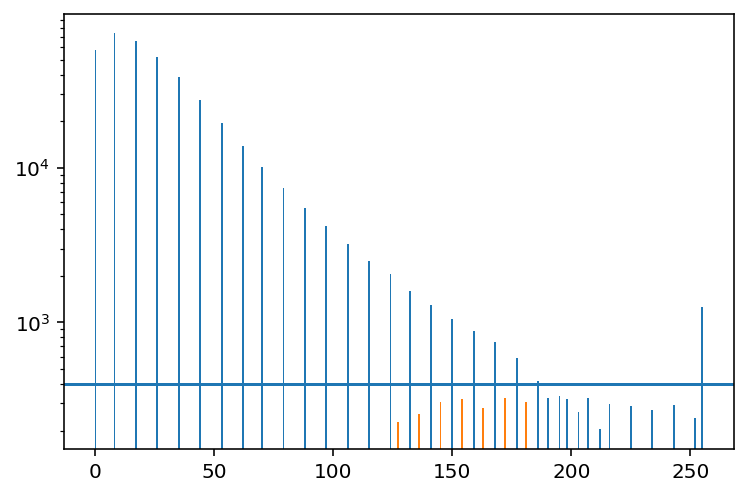

In [48]:
th = 4e2
plt.axhline(th)
take = x[y<th]
take = take[take<190]

tmp = tmp[np.isin(tmp,take)]
x,y = np.array(tally(tmp)).T
plt.bar(x,y)

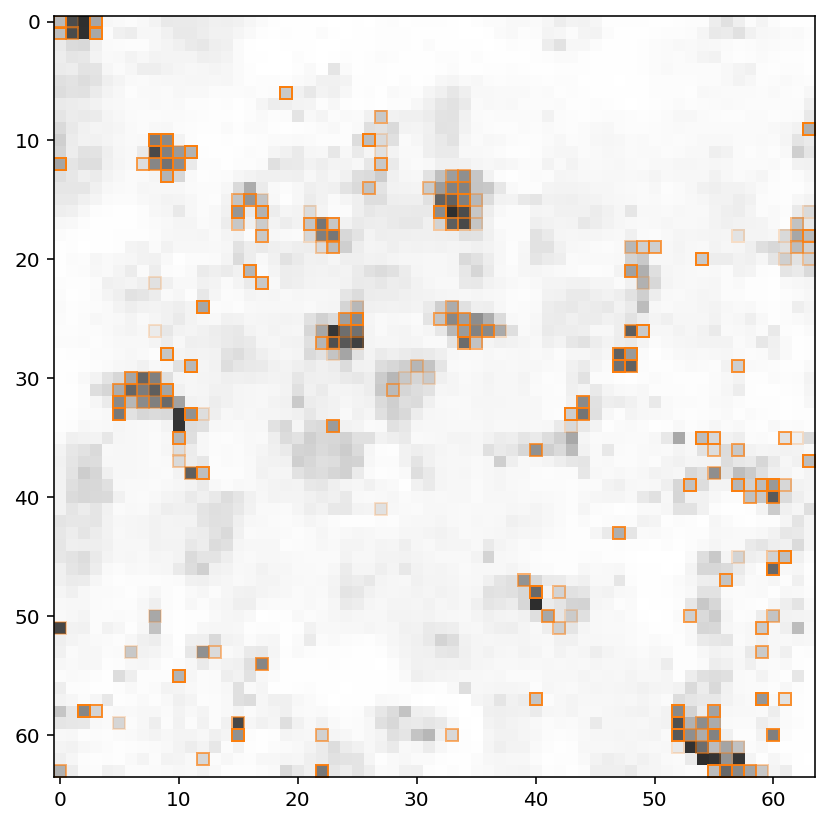

In [49]:
plt.figure(figsize=(7,7))
plt.imshow(np.mean(ims,axis=0).T, cmap="Greys",vmax=300)
for t,x,y in zip(*np.where(np.isin(ims,take))):
    plt.plot(x,y,"C1s",
             alpha = .2,
             mfc="none"
            )
    #, )#,mec="C1")

In [85]:
from scipy.stats import distributions as dst

(-13.190000000000001, 268.19)

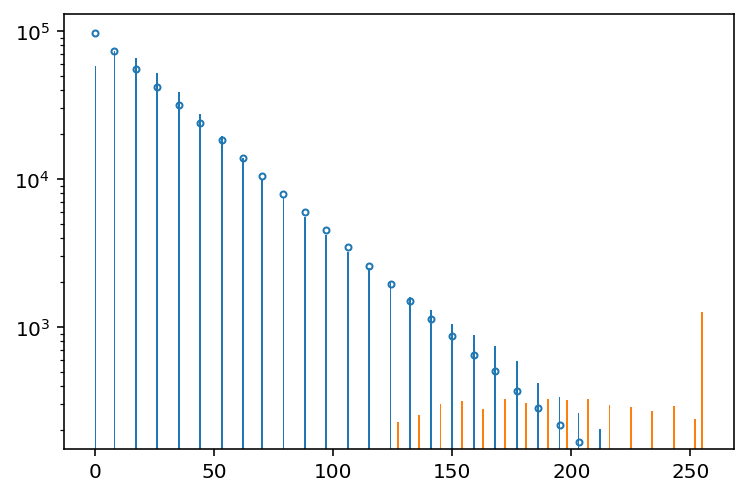

In [51]:
# x,y = np.array(tally(ims.flatten())).T
# plt.bar(x,y)

x,y = np.array(tally(ims.T[1:-1].flatten())).T
plt.bar(x,y)

plt.yscale("log")
xl = plt.xlim()

realxx = dst.expon.rvs(scale=3.6,size=(2,int(1e6)))
for xx in [
    (realxx.flatten()  .astype( int)*8.865).astype(int),
]:
    xr,yr = np.array(tally(xx)).T
    plt.plot(xr,yr/yr.sum()*y.sum(),".", mfc="none")

    
ims_r = ims[:,:,1:-1]
xr,yr = np.array(tally(ims_r[~np.isin(ims_r,xr)].flatten())).T


plt.bar(xr,yr)
# # plt.bar(xr,yr/yr.sum()*1,color="C2")

plt.xlim(xl)

In [52]:
take = xr

In [53]:
imsf = ims.astype(float)

In [54]:
imsf[~np.isin(imsf,take)] = np.nan

/Users/srdjan/anaconda2/envs/physio/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


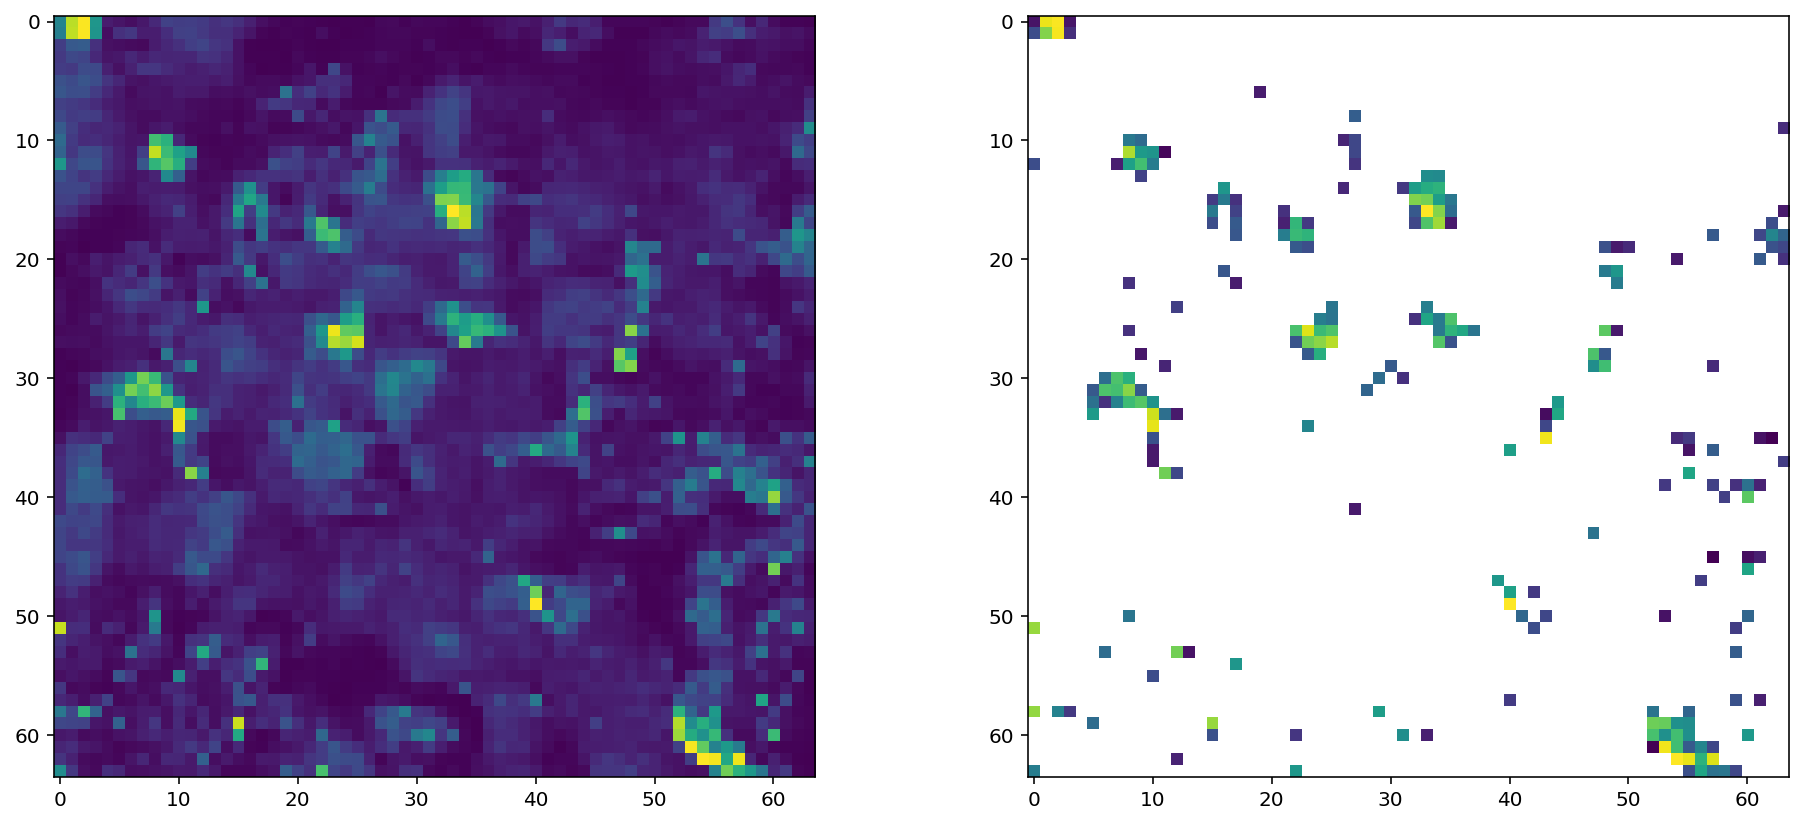

In [55]:
fig,axs = plt.subplots(1,2,figsize=(16,7))
axs[0].imshow(np.nanmean(ims ,axis=0).T)
axs[1].imshow(np.nanmean(imsf,axis=0).T)
# for t,x,y in zip(*np.where(np.isin(ims[::1000],take))):
#     plt.plot(x,y,"C1s",
#              alpha = .2,
#              mfc="none"
#             )
#     #, )#,mec="C1")

# Kill javabridge

In [ ]:
javabridge.kill_vm()